In [1]:
!pip install -q darts

In [2]:
!pip install -q matplotlib==3.1.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbit-ml 1.0.17 requires matplotlib>=3.3.2, but you have matplotlib 3.1.3 which is incompatible.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
darts 0.14.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import RNNModel, BlockRNNModel, TCNModel, ARIMA, AutoARIMA, TransformerModel, Prophet
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape
import matplotlib.pyplot as plt

In [55]:
df = pd.read_csv('/content/airline-passengers.csv')

In [5]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
series = TimeSeries.from_dataframe(df,'Month','Passengers')

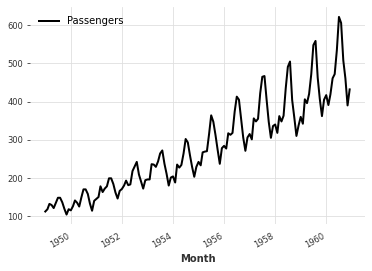

In [7]:
series.plot()

In [8]:
# Create training and validation sets:
train, val = series.split_after(pd.Timestamp('19600101'))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create month and year covariate series
year_series = datetime_attribute_timeseries(pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000),
                                             attribute='year', one_hot=False)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(year_series, attribute='month', one_hot=True)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp('19600101'))

# 1. RNN Univariate

In [9]:
Rnn = RNNModel(
    model='LSTM',
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=500,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='Air_RNN',
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=12,
    force_reset=True
)

In [10]:
Rnn.fit(train_transformed,
             verbose=True)

[2021-12-15 12:03:33,189] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 113 samples.
[2021-12-15 12:03:33,189] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 113 samples.
[2021-12-15 12:03:33,201] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-15 12:03:33,201] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  0%|          | 2/500 [00:00<00:45, 10.99it/s]

  2%|▏         | 12/500 [00:01<00:43, 11.25it/s]

  4%|▍         | 22/500 [00:01<00:41, 11.55it/s]

  6%|▋         | 32/500 [00:02<00:40, 11.57it/s]

  8%|▊         | 42/500 [00:03<00:39, 11.46it/s]

 10%|█         | 52/500 [00:04<00:39, 11.42it/s]

 12%|█▏        | 62/500 [00:05<00:39, 11.04it/s]

 14%|█▍        | 72/500 [00:06<00:55,  7.77it/s]

 16%|█▋        | 82/500 [00:08<01:13,  5.71it/s]

 18%|█▊        | 92/500 [00:10<01:20,  5.05it/s]

 20%|██        | 102/500 [00:12<01:14,  5.34it/s]

 22%|██▏       | 112/500 [00:14<01:11,  5.43it/s]

 24%|██▍       | 122/500 [00:16<01:29,  4.22it/s]

 26%|██▌       | 131/500 [00:18<01:20,  4.57it/s]

 28%|██▊       | 142/500 [00:21<01:02,  5.71it/s]

 30%|███       | 151/500 [00:23<01:29,  3.89it/s]

 32%|███▏      | 161/500 [00:25<01:09,  4.87it/s]

 34%|███▍      | 172/500 [00:27<00:55,  5.92it/s]

 37%|███▋      | 183/500 [00:28<00:32,  9.80it/s]

 39%|███▊      | 193/500 [00:29<00:26, 11.49it/s]

 41%|████      | 203/500 [00:30<00:25, 11.62it/s]

 43%|████▎     | 213/500 [00:31<00:24, 11.73it/s]

 45%|████▍     | 223/500 [00:32<00:23, 11.56it/s]

 47%|████▋     | 233/500 [00:33<00:22, 11.84it/s]

 49%|████▊     | 243/500 [00:34<00:21, 11.74it/s]

 51%|█████     | 253/500 [00:34<00:20, 11.82it/s]

 53%|█████▎    | 263/500 [00:35<00:20, 11.72it/s]

 55%|█████▍    | 273/500 [00:36<00:19, 11.55it/s]

 57%|█████▋    | 283/500 [00:37<00:18, 11.50it/s]

 59%|█████▊    | 293/500 [00:38<00:17, 11.67it/s]

 61%|██████    | 303/500 [00:39<00:16, 11.89it/s]

 63%|██████▎   | 313/500 [00:40<00:15, 11.86it/s]

 65%|██████▍   | 323/500 [00:40<00:15, 11.68it/s]

 67%|██████▋   | 333/500 [00:41<00:14, 11.78it/s]

 69%|██████▊   | 343/500 [00:42<00:13, 11.77it/s]

 71%|███████   | 353/500 [00:43<00:12, 11.90it/s]

 73%|███████▎  | 363/500 [00:44<00:11, 11.83it/s]

 75%|███████▍  | 373/500 [00:45<00:10, 11.68it/s]

 77%|███████▋  | 383/500 [00:45<00:09, 11.98it/s]

 79%|███████▊  | 393/500 [00:46<00:08, 11.94it/s]

 81%|████████  | 403/500 [00:47<00:08, 11.68it/s]

 83%|████████▎ | 413/500 [00:48<00:07, 11.66it/s]

 85%|████████▍ | 423/500 [00:49<00:06, 11.32it/s]

 87%|████████▋ | 433/500 [00:50<00:05, 11.95it/s]

 89%|████████▊ | 443/500 [00:51<00:04, 11.68it/s]

 91%|█████████ | 453/500 [00:52<00:04, 11.65it/s]

 93%|█████████▎| 463/500 [00:52<00:03, 11.60it/s]

 95%|█████████▍| 473/500 [00:53<00:02, 11.85it/s]

 97%|█████████▋| 483/500 [00:54<00:01, 11.91it/s]

 99%|█████████▊| 493/500 [00:55<00:00, 11.85it/s]

100%|██████████| 500/500 [00:55<00:00,  8.93it/s]


In [11]:
Rnn_predicted = Rnn.predict(n=len(val_transformed))

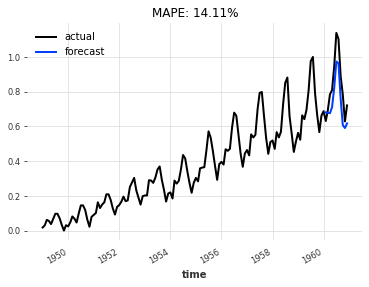

In [12]:
series_transformed.plot(label='actual')
Rnn_predicted.plot(label='forecast')
plt.title('MAPE: {:.2f}%'.format(mape(Rnn_predicted, val_transformed)))
plt.legend()
plt.show()

# 2. RNN Future covaraite

In [13]:
Rnn_future = RNNModel(
    model='LSTM',
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=500,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='Air_RNN',
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=12,
    force_reset=True
)

In [14]:
Rnn_future.fit(train_transformed,
             future_covariates=covariates,
             verbose=True)

[2021-12-15 12:04:34,229] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 113 samples.
[2021-12-15 12:04:34,229] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 113 samples.
[2021-12-15 12:04:34,237] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-15 12:04:34,237] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  0%|          | 2/500 [00:00<00:55,  8.97it/s]

  2%|▏         | 12/500 [00:01<00:55,  8.77it/s]

  4%|▍         | 22/500 [00:02<00:56,  8.45it/s]

  6%|▋         | 32/500 [00:03<00:54,  8.57it/s]

  8%|▊         | 42/500 [00:04<00:52,  8.76it/s]

 10%|█         | 52/500 [00:06<00:51,  8.73it/s]

 12%|█▏        | 62/500 [00:07<00:50,  8.75it/s]

 14%|█▍        | 72/500 [00:08<00:48,  8.90it/s]

 16%|█▋        | 82/500 [00:09<00:49,  8.49it/s]

 18%|█▊        | 92/500 [00:10<00:46,  8.69it/s]

 20%|██        | 102/500 [00:11<00:46,  8.60it/s]

 22%|██▏       | 112/500 [00:12<00:44,  8.81it/s]

 24%|██▍       | 122/500 [00:14<00:43,  8.78it/s]

 26%|██▋       | 132/500 [00:15<00:40,  8.98it/s]

 28%|██▊       | 142/500 [00:16<00:41,  8.65it/s]

 30%|███       | 152/500 [00:17<00:39,  8.90it/s]

 32%|███▏      | 162/500 [00:18<00:39,  8.50it/s]

 34%|███▍      | 172/500 [00:19<00:36,  8.99it/s]

 36%|███▋      | 182/500 [00:20<00:36,  8.63it/s]

 38%|███▊      | 192/500 [00:22<00:35,  8.65it/s]

 40%|████      | 202/500 [00:23<00:33,  8.93it/s]

 42%|████▏     | 212/500 [00:24<00:32,  8.83it/s]

 44%|████▍     | 222/500 [00:25<00:31,  8.87it/s]

 46%|████▋     | 232/500 [00:26<00:30,  8.84it/s]

 48%|████▊     | 242/500 [00:27<00:28,  9.13it/s]

 50%|█████     | 252/500 [00:28<00:27,  8.92it/s]

 52%|█████▏    | 262/500 [00:30<00:27,  8.70it/s]

 54%|█████▍    | 272/500 [00:31<00:25,  8.82it/s]

 56%|█████▋    | 282/500 [00:32<00:24,  8.80it/s]

 58%|█████▊    | 292/500 [00:33<00:23,  8.83it/s]

 60%|██████    | 302/500 [00:34<00:22,  8.73it/s]

 62%|██████▏   | 312/500 [00:35<00:21,  8.83it/s]

 64%|██████▍   | 322/500 [00:36<00:20,  8.73it/s]

 66%|██████▋   | 332/500 [00:38<00:19,  8.79it/s]

 68%|██████▊   | 342/500 [00:39<00:17,  8.92it/s]

 70%|███████   | 352/500 [00:40<00:16,  8.83it/s]

 72%|███████▏  | 362/500 [00:41<00:16,  8.37it/s]

 74%|███████▍  | 372/500 [00:42<00:14,  8.69it/s]

 76%|███████▋  | 382/500 [00:43<00:13,  8.69it/s]

 78%|███████▊  | 392/500 [00:44<00:12,  8.75it/s]

 80%|████████  | 402/500 [00:46<00:11,  8.73it/s]

 82%|████████▏ | 412/500 [00:47<00:09,  8.96it/s]

 84%|████████▍ | 422/500 [00:48<00:08,  8.88it/s]

 86%|████████▋ | 432/500 [00:49<00:07,  8.82it/s]

 88%|████████▊ | 442/500 [00:50<00:06,  8.66it/s]

 90%|█████████ | 452/500 [00:51<00:05,  8.34it/s]

 92%|█████████▏| 462/500 [00:52<00:04,  8.51it/s]

 94%|█████████▍| 472/500 [00:54<00:03,  8.88it/s]

 96%|█████████▋| 482/500 [00:55<00:02,  8.55it/s]

 98%|█████████▊| 492/500 [00:56<00:00,  8.73it/s]

100%|██████████| 500/500 [00:57<00:00,  8.72it/s]


In [15]:
Rnn_future_predicted = Rnn_future.predict(n=len(val_transformed))

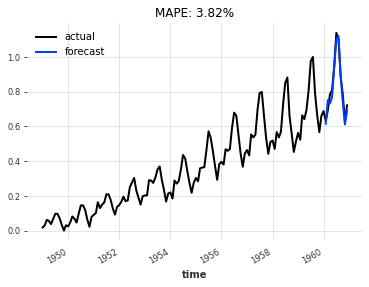

In [16]:
series_transformed.plot(label='actual')
Rnn_future_predicted.plot(label='forecast')
plt.title('MAPE: {:.2f}%'.format(mape(Rnn_future_predicted, val_transformed)))
plt.legend()
plt.show()

# 3. BlockRNN past covaraite

In [17]:
Rnn_past = BlockRNNModel(
    model='LSTM',
    input_chunk_length=12,
    output_chunk_length=10,
    n_epochs=300,
    random_state=0
)

In [18]:
Rnn_past.fit(train_transformed,
             past_covariates=cov_train,
             verbose=True)

[2021-12-15 12:05:32,069] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 112 samples.
[2021-12-15 12:05:32,069] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 112 samples.
[2021-12-15 12:05:32,077] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-15 12:05:32,077] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  2%|▏         | 5/300 [00:00<00:14, 20.56it/s]

  5%|▍         | 14/300 [00:00<00:13, 21.99it/s]

  8%|▊         | 23/300 [00:01<00:12, 21.73it/s]

 12%|█▏        | 35/300 [00:01<00:11, 22.57it/s]

 15%|█▍        | 44/300 [00:01<00:11, 22.64it/s]

 18%|█▊        | 53/300 [00:02<00:10, 22.64it/s]

 22%|██▏       | 65/300 [00:02<00:10, 22.94it/s]

 24%|██▎       | 71/300 [00:03<00:10, 22.47it/s]

 28%|██▊       | 84/300 [00:04<00:14, 15.38it/s]

 30%|███       | 91/300 [00:05<00:21,  9.86it/s]

 35%|███▍      | 104/300 [00:05<00:11, 17.52it/s]

 38%|███▊      | 113/300 [00:06<00:16, 11.47it/s]

 41%|████▏     | 124/300 [00:07<00:09, 18.13it/s]

 44%|████▍     | 133/300 [00:07<00:07, 20.90it/s]

 48%|████▊     | 145/300 [00:08<00:07, 21.96it/s]

 51%|█████▏    | 154/300 [00:08<00:06, 22.23it/s]

 54%|█████▍    | 163/300 [00:09<00:06, 22.65it/s]

 58%|█████▊    | 175/300 [00:09<00:05, 22.74it/s]

 61%|██████▏   | 184/300 [00:10<00:05, 22.29it/s]

 64%|██████▍   | 193/300 [00:10<00:04, 21.78it/s]

 68%|██████▊   | 205/300 [00:11<00:04, 21.66it/s]

 71%|███████▏  | 214/300 [00:11<00:04, 21.40it/s]

 74%|███████▍  | 223/300 [00:11<00:03, 21.44it/s]

 78%|███████▊  | 235/300 [00:12<00:03, 21.41it/s]

 81%|████████▏ | 244/300 [00:12<00:02, 21.75it/s]

 84%|████████▍ | 253/300 [00:13<00:02, 21.87it/s]

 88%|████████▊ | 265/300 [00:13<00:01, 22.49it/s]

 91%|█████████▏| 274/300 [00:14<00:01, 22.64it/s]

 94%|█████████▍| 283/300 [00:14<00:00, 22.26it/s]

 98%|█████████▊| 295/300 [00:15<00:00, 22.68it/s]

100%|██████████| 300/300 [00:15<00:00, 19.41it/s]


In [19]:
Rnn_past_predicted = Rnn_past.predict(n=10)

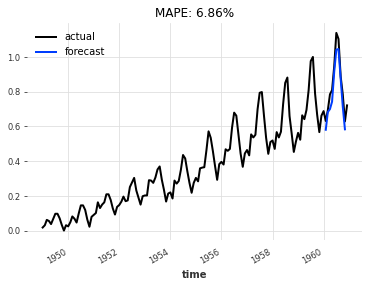

In [20]:
series_transformed.plot(label='actual')
Rnn_past_predicted.plot(label='forecast')
plt.title('MAPE: {:.2f}%'.format(mape(Rnn_past_predicted, val_transformed[:11])))
plt.legend()
plt.show()

# 4. TCN past covariate

In [21]:
Tcn_past = TCNModel(
    input_chunk_length=12,
    output_chunk_length=10,
    n_epochs=300,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    batch_size=50,
    num_filters=3,
    random_state=0
)

In [22]:
Tcn_past.fit(train_transformed,
             past_covariates=cov_train,
             verbose=True)

[2021-12-15 12:05:47,988] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 112 samples.
[2021-12-15 12:05:47,988] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 112 samples.
[2021-12-15 12:05:47,995] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 2
[2021-12-15 12:05:47,995] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 2
[2021-12-15 12:05:48,004] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-15 12:05:48,004] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  1%|          | 3/300 [00:00<00:14, 20.76it/s]

  5%|▌         | 15/300 [00:00<00:12, 21.98it/s]

  8%|▊         | 24/300 [00:01<00:12, 22.58it/s]

 11%|█         | 33/300 [00:01<00:11, 22.53it/s]

 15%|█▌        | 45/300 [00:02<00:11, 22.60it/s]

 18%|█▊        | 54/300 [00:02<00:11, 22.32it/s]

 21%|██        | 63/300 [00:02<00:10, 22.10it/s]

 25%|██▌       | 75/300 [00:03<00:10, 22.36it/s]

 28%|██▊       | 84/300 [00:03<00:09, 21.94it/s]

 31%|███       | 93/300 [00:04<00:09, 22.97it/s]

 35%|███▌      | 105/300 [00:04<00:08, 22.18it/s]

 38%|███▊      | 114/300 [00:05<00:08, 22.39it/s]

 41%|████      | 123/300 [00:05<00:07, 22.87it/s]

 45%|████▌     | 135/300 [00:06<00:07, 22.96it/s]

 48%|████▊     | 144/300 [00:06<00:06, 23.03it/s]

 51%|█████     | 153/300 [00:06<00:06, 21.86it/s]

 55%|█████▌    | 165/300 [00:07<00:06, 22.18it/s]

 58%|█████▊    | 174/300 [00:07<00:05, 22.34it/s]

 61%|██████    | 183/300 [00:08<00:05, 22.04it/s]

 65%|██████▌   | 195/300 [00:08<00:04, 22.55it/s]

 68%|██████▊   | 204/300 [00:09<00:04, 21.72it/s]

 71%|███████   | 213/300 [00:09<00:03, 22.48it/s]

 75%|███████▌  | 225/300 [00:10<00:03, 22.14it/s]

 78%|███████▊  | 234/300 [00:10<00:02, 22.65it/s]

 81%|████████  | 243/300 [00:10<00:02, 22.41it/s]

 85%|████████▌ | 255/300 [00:11<00:01, 22.72it/s]

 88%|████████▊ | 264/300 [00:11<00:01, 22.16it/s]

 91%|█████████ | 273/300 [00:12<00:01, 22.12it/s]

 95%|█████████▌| 285/300 [00:12<00:00, 22.78it/s]

 98%|█████████▊| 294/300 [00:13<00:00, 22.17it/s]

100%|██████████| 300/300 [00:13<00:00, 22.34it/s]


In [23]:
Tcn_past_predicted = Tcn_past.predict(n=10)

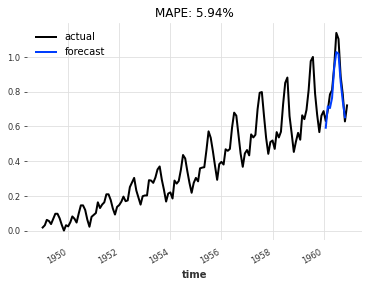

In [24]:
series_transformed.plot(label='actual')
Tcn_past_predicted.plot(label='forecast')
plt.title('MAPE: {:.2f}%'.format(mape(Tcn_past_predicted, val_transformed[:11])))
plt.legend()
plt.show()

# 5. ARIMA

In [25]:
arima = ARIMA()

In [26]:
arima.fit(train_transformed)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [27]:
arima_predicted = arima.predict(n=len(val_transformed))

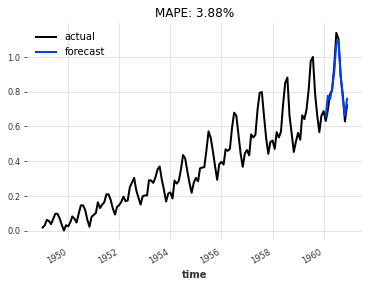

In [28]:
series_transformed.plot(label='actual')
arima_predicted.plot(label='forecast')
plt.title('MAPE: {:.2f}%'.format(mape(arima_predicted, val_transformed)))
plt.legend()
plt.show()

# 6. Transformer past covaraite

In [29]:
transformer = TransformerModel(
    input_chunk_length=12,
    output_chunk_length=10,
    n_epochs=300,
    random_state=0
)

In [30]:
transformer.fit(train_transformed,
             past_covariates=cov_train,
             verbose=True)

[2021-12-15 12:06:03,724] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 112 samples.
[2021-12-15 12:06:03,724] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 112 samples.
[2021-12-15 12:06:03,754] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-15 12:06:03,754] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  0%|          | 1/300 [00:00<01:28,  3.36it/s]

  4%|▎         | 11/300 [00:02<01:16,  3.77it/s]

  7%|▋         | 21/300 [00:05<01:13,  3.78it/s]

 10%|█         | 31/300 [00:08<01:10,  3.80it/s]

 14%|█▎        | 41/300 [00:10<01:08,  3.75it/s]

 17%|█▋        | 51/300 [00:13<01:05,  3.79it/s]

 20%|██        | 61/300 [00:16<01:02,  3.84it/s]

 24%|██▎       | 71/300 [00:18<01:00,  3.79it/s]

 27%|██▋       | 81/300 [00:21<00:57,  3.82it/s]

 30%|███       | 91/300 [00:24<00:55,  3.77it/s]

 34%|███▎      | 101/300 [00:26<00:51,  3.84it/s]

 37%|███▋      | 111/300 [00:29<00:49,  3.83it/s]

 40%|████      | 121/300 [00:31<00:46,  3.87it/s]

 44%|████▎     | 131/300 [00:34<00:43,  3.85it/s]

 47%|████▋     | 141/300 [00:37<00:41,  3.79it/s]

 50%|█████     | 151/300 [00:39<00:38,  3.85it/s]

 54%|█████▎    | 161/300 [00:42<00:36,  3.84it/s]

 57%|█████▋    | 171/300 [00:44<00:33,  3.86it/s]

 60%|██████    | 181/300 [00:47<00:31,  3.80it/s]

 64%|██████▎   | 191/300 [00:50<00:28,  3.84it/s]

 67%|██████▋   | 201/300 [00:52<00:25,  3.84it/s]

 70%|███████   | 211/300 [00:55<00:23,  3.84it/s]

 74%|███████▎  | 221/300 [00:57<00:20,  3.82it/s]

 77%|███████▋  | 231/300 [01:00<00:17,  3.90it/s]

 80%|████████  | 241/300 [01:03<00:15,  3.86it/s]

 84%|████████▎ | 251/300 [01:05<00:12,  3.80it/s]

 87%|████████▋ | 261/300 [01:08<00:10,  3.88it/s]

 90%|█████████ | 271/300 [01:11<00:07,  3.82it/s]

 94%|█████████▎| 281/300 [01:13<00:04,  3.84it/s]

 97%|█████████▋| 291/300 [01:16<00:02,  3.86it/s]

100%|██████████| 300/300 [01:18<00:00,  3.82it/s]


In [31]:
transformer_past_predicted = transformer.predict(n=10)

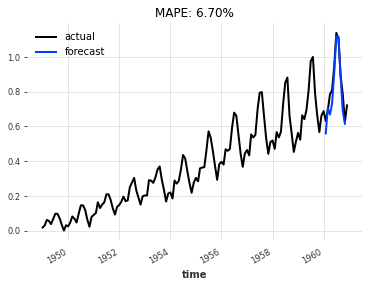

In [32]:
series_transformed.plot(label='actual')
transformer_past_predicted.plot(label='forecast')
plt.title('MAPE: {:.2f}%'.format(mape(transformer_past_predicted, val_transformed[:11])))
plt.legend()
plt.show()

# 7. Prohpet

In [33]:
prohpet = Prophet()

In [34]:
prohpet.fit(train_transformed)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
prohpet_predicted = prohpet.predict(n=len(val_transformed))

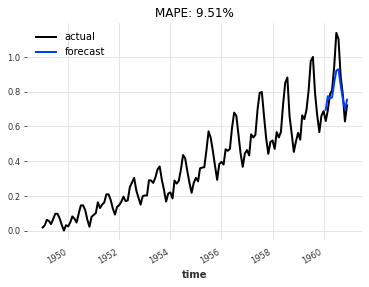

In [36]:
series_transformed.plot(label='actual')
prohpet_predicted.plot(label='forecast')
plt.title('MAPE: {:.2f}%'.format(mape(prohpet_predicted, val_transformed[:11])))
plt.legend()
plt.show()

# Other Darts

In [37]:
!pip install -q neuralprophet

In [38]:
from neuralprophet import NeuralProphet
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [56]:
df_new = df.copy()

In [57]:
df_new['Month'] = pd.to_datetime(df_new['Month'])

In [58]:
scaler = MinMaxScaler()

In [59]:
scaled_values = scaler.fit_transform(np.expand_dims(df_new['Passengers'].values, axis=1))
df_new['transformed_passengers'] = pd.Series(np.squeeze(scaled_values))

In [61]:
def create_year_month_one_hot_encoding(df):
    df['year'] = df['Month'].dt.year
    df['month'] = df['Month'].dt.month
    df = pd.get_dummies(df, columns=[ 'month'])
    return df

In [62]:
new_df = create_year_month_one_hot_encoding(df_new).copy()

In [63]:
scaled_values = scaler.fit_transform(np.expand_dims(new_df['year'].values, axis=1))
new_df['transformed_year'] = pd.Series(np.squeeze(scaled_values))

In [64]:
new_df.head()

,Month,Passengers,transformed_passengers,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,transformed_year
0,1949-01-01,112,0.015444,1949,1,0,0,0,0,0,0,0,0,0,0,0,0.0
1,1949-02-01,118,0.027027,1949,0,1,0,0,0,0,0,0,0,0,0,0,0.0
2,1949-03-01,132,0.054054,1949,0,0,1,0,0,0,0,0,0,0,0,0,0.0
3,1949-04-01,129,0.048263,1949,0,0,0,1,0,0,0,0,0,0,0,0,0.0
4,1949-05-01,121,0.032819,1949,0,0,0,0,1,0,0,0,0,0,0,0,0.0


In [65]:
new_df.columns

Index(['Month', 'Passengers', 'transformed_passengers', 'year', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'transformed_year'],
      dtype='object')

# 8. Neural Prophet 

In [66]:
neural_prophet_df = new_df.copy()

In [67]:
neural_prophet_df.rename(columns = {'Month':'ds', 'transformed_passengers':'y'}, inplace = True)

In [68]:
test_size = 10
train_df = neural_prophet_df[:-test_size].copy()
test_df = neural_prophet_df[-test_size:].copy()

In [69]:
m = NeuralProphet()

In [70]:
m.fit(neural_prophet_df[['ds','y']],freq='M', epochs=300)

INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16


  0%|          | 0/209 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.26E-01, min: 3.73E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.26E-01, min: 3.73E+00


  0%|          | 0/209 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.14E-01, min: 1.86E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.14E-01, min: 1.86E+00


  0%|          | 0/209 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.03E-01, min: 2.51E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.03E-01, min: 2.51E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.14E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.14E-01
Epoch[300/300]: 100%|██████████| 300/300 [00:07<00:00, 42.80it/s, SmoothL1Loss=0.00153, MAE=0.031, RMSE=0.0402, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,2.149406,1.979336,2.077673,0.0
1,2.127268,1.962793,2.067042,0.0
2,2.104310,1.945632,2.047246,0.0
3,2.078667,1.926465,2.024084,0.0
4,2.049010,1.904287,2.006683,0.0
...,...,...,...,...
295,0.001528,0.031007,0.040579,0.0
296,0.001528,0.031004,0.040053,0.0
297,0.001528,0.031003,0.040572,0.0
298,0.001528,0.031002,0.040506,0.0


In [71]:
future = m.make_future_dataframe(train_df[['ds','y']], periods=10)

In [72]:
forecast = m.predict(future)

In [73]:
forecast

,ds,y,yhat1,residual1,trend,season_yearly
0,1960-02-29,None,0.692968,NaN,0.691347,0.001621
1,1960-03-31,None,0.684631,NaN,0.699926,-0.015295
2,1960-04-30,None,0.702944,NaN,0.708229,-0.005284
3,1960-05-31,None,0.774681,NaN,0.716808,0.057873
4,1960-06-30,None,0.862249,NaN,0.725110,0.137139
5,1960-07-31,None,0.861019,NaN,0.733689,0.127330
6,1960-08-31,None,0.778305,NaN,0.742268,0.036037
7,1960-09-30,None,0.704068,NaN,0.750571,-0.046503
8,1960-10-31,None,0.648911,NaN,0.759150,-0.110239
9,1960-11-30,None,0.697394,NaN,0.767452,-0.070058


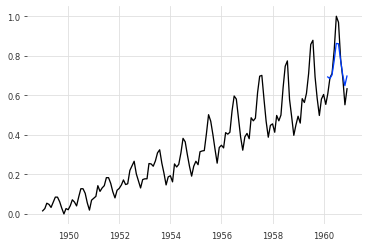

In [74]:
plt.plot(neural_prophet_df['ds'],neural_prophet_df['y'])
plt.plot(forecast['ds'],forecast['yhat1'])

# 9 Orbit Bayesian model

In [75]:
!pip install -q orbit-ml

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [76]:
from orbit.models.dlt import DLTFull 
from orbit.diagnostics.plot import plot_predicted_data

In [77]:
test_size = 10
train_df = new_df[:-test_size].copy()
test_df = new_df[-test_size:].copy()

In [78]:
dlt = DLTFull(
  response_col='transformed_passengers', date_col='Month',
  seasonality=12,
)

In [79]:
dlt.fit(df=train_df)

In [80]:
ne = test_df[['Month','year']]

In [81]:
predicted_df = dlt.predict(ne)

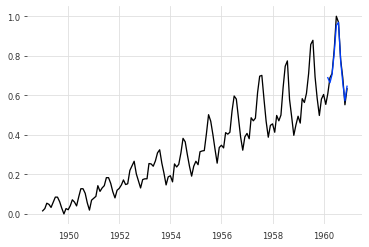

In [82]:
plt.plot(new_df['Month'],new_df['transformed_passengers'])
plt.plot(predicted_df['Month'], predicted_df['prediction'])